# Fine-tuning models with the kluster.ai API

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/finetuning-sent-analysis.ipynb)

## Introduction

Fine-tuning is the process of customizing an existing model using new data to improve performance on a specific task. Fine-tuning can offer valuable benefits: it can significantly improve performance for your specific use case and sometimes rival the results of more expensive, general-purpose models.

In this guide, you'll learn how to train a sentiment analysis model tailored to your data using <a href="https://kluster.ai/" target="_blank">kluster.ai</a>. We'll walk through each step of the fine-tuning process—covering dataset setup, environment configuration, and batch inference. By following along, you'll discover how to leverage kluster.ai's powerful platform to create a custom model that boosts accuracy for financial text analysis and beyond.

## Prerequisites

Before getting started, ensure you have the following:

- **A kluster.ai account** - sign up on the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> if you don't have one
- **A kluster.ai API key** - after signing in, go to the <a href="https://platform.kluster.ai/apikeys" target="_blank">**API Keys**</a> section and create a new key. For detailed instructions, check out the <a href="https://docs.kluster.ai/get-started/get-api-key/" target="_blank">Get an API key</a> guide

## Setup

In this notebook, we'll use Python's `getpass` module to safely input the key. Provide your unique kluster.ai API key (ensure there are no spaces).

In [ ]:
from getpass import getpass

api_key = getpass("Enter your kluster.ai API key: ")

In [ ]:
%pip install -q openai

In [ ]:
import urllib.request
import pandas as pd
from openai import OpenAI
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)

# Import helper functions
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/main/examples/helpers.py"

# Fetch the file and save it locally
response = requests.get(url)
with open("helpers.py", "w") as f:
    f.write(response.text)

# Import the helper functions
from helpers import create_tasks, save_tasks, create_batch_job, monitor_job_status, get_results


In [ ]:
# Set up the client
client_prod = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Fetch a real dataset for batch inference

This dataset contains a variety of financial news headlines, each labeled as positive, negative, or neutral. In this context, positive indicates a beneficial impact on the company’s stock, negative suggests a detrimental impact, and neutral implies no significant change is expected.

In this example, we limit the dataset to the first 4000 rows of the financial phrasebank, resulting in 400 training examples after splitting. For a faster running example, you can select as little as 100 rows of data, as kluster.ai requires a minimum of 10 examples.

In [ ]:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/main/data/financial-phrasebank.csv"
urllib.request.urlretrieve(url,filename='financial-phrasebank.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('financial-phrasebank.csv', encoding = "ISO-8859-1",header=None, names=["sentiment", "text"])

# For a faster running example, adjust the below variable to select a smaller subset of financial training content. Must be > 100.
df = df.iloc[:4000]
df.head(3)

### Split data into train/test for fine-tuning

Next, we need to split the data into training and testing datasets (to be used later).

In [ ]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.9, random_state=42)

In [ ]:
len(train_df)

## Fine-tuning the model

Fine-tuning is the process of adjusting a pre-trained model with new, domain-specific data to enhance performance for a specific task, which typically reduces training time and costs compared to training from scratch. Additionally, it can allow smaller, fine-tuned models to match or even rival the performance of larger, general models that haven’t been fine-tuned.

In [ ]:
SYSTEM_PROMPT = '''
    You are a helpful assistant specializing in determining the sentiment of financial news.
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.
    Provide your response as a single word without any punctuation.
    '''

# Ensure the directory exists
os.makedirs("finetuning/data", exist_ok=True)

# Generate JSONLines file
with open("finetuning/data/sentiment.jsonl", "w") as f:
    for _, row in train_df.iterrows():
        # Create the message structure
        messages = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": row['text']},
                {"role": "assistant", "content": row["sentiment"]}
            ]
        }
        # Write to the file as a single JSON object per line
        f.write(json.dumps(messages) + "\n")

In [ ]:
data_dir = 'finetuning/data/sentiment.jsonl'

with open(data_dir, 'rb') as file:
    upload_response = client_prod.files.create(
        file=file,
        purpose="fine-tune"
    )
    file_id = upload_response.id
    print(f"File uploaded successfully. File ID: {file_id}")

Next, we'll submit the job to the kluster.ai fine-tuning API. Currently, two base models are supported for fine-tuning:
- klusterai/Meta-Llama-3.1-8B-Instruct-Turbo
- klusterai/Meta-Llama-3.3-70B-Instruct-Turbo

If you specify a different base model, the fine-tuning job will fail. You can also tweak the hyperparameters (such as number of epochs, batch size, and learning rate) to adjust training time and potential performance gains. Remember that increasing the number of epochs will lead to longer training time but may result in higher performance. If you're unsure which hyperparameters to set, you can also comment them out to accept the default values.

In [ ]:
job = client_prod.fine_tuning.jobs.create(
    training_file=file_id,
    model="klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
    #hyperparameters={
    #   "batch_size": 4,
    #   "n_epochs": 2,
    #   "learning_rate_multiplier": 1
    #}
)
print("\nFine-tuning job created:")
print(json.dumps(job.model_dump(), indent=2))


Fine-tuning job created:
{
  "id": "67b504e2451f71cc68416fb5",
  "created_at": 1739916514,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "batch_size": 1,
    "learning_rate_multiplier": 1.0,
    "n_epochs": 10
  },
  "model": "meta-llama/Llama-3.1-8B-Instruct",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [],
  "seed": null,
  "status": "queued",
  "trained_tokens": null,
  "training_file": "67b504e1e56b50d27357b6b0",
  "validation_file": null,
  "estimated_finish": null,
  "integrations": [],
  "method": {
    "dpo": null,
    "supervised": {
      "hyperparameters": null,
      "batch_size": 1,
      "learning_rate_multiplier": 1,
      "n_epochs": 10
    },
    "type": "supervised"
  }
}


Next, we can retrieve the status of the job through its ID. The following snippet checks the status every 30 seconds.

In [ ]:
while True:
    job_status = client_prod.fine_tuning.jobs.retrieve(job.id)
    status = job_status.status
    print(f"\nCurrent status: {status}")

    events = client_prod.fine_tuning.jobs.list_events(job.id)
    events_list = [e.model_dump() for e in events]
    events_list.sort(key=lambda x: x['created_at'])
    print("\nJob events:")
    print(json.dumps(events_list, indent=2))

    if status in ["succeeded", "failed", "cancelled"]:
        break

    time.sleep(30)


Current status: validating_files

Job events:
[
  {
    "id": "67b504e26913e957964c1232",
    "created_at": 1739916514,
    "level": "info",
    "message": "Validating training file: 67b504e1e56b50d27357b6b0",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "67b504e2451f71cc68416fb7",
    "created_at": 1739916514,
    "level": "info",
    "message": "Created fine-tuning job: 67b504e2451f71cc68416fb5",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  }
]



In [ ]:
fine_tuned_model = job_status.fine_tuned_model

In [ ]:
job_status.fine_tuned_model

Congratulations! You've now created a fine-tuned model. The exact name of your fine-tuned model is above.

In the next section, you'll submit batch requests to your fine-tuned model. However, you can also submit one-off requests as follows (remember to provide your kluster.ai API key and the name of your fine-tuned model):

```bash
curl https://api.kluster.ai/v1/chat/completions \
  -H "Authorization: Bearer INSERT_API_KEY" \
  -H "Content-Type: application/json" \
  -d '{
    "model": "INSERT_FINE_TUNED_MODEL",
    "max_completion_tokens": 5000,
    "temperature": 0.6,
    "top_p": 1,
    "messages": [
      {
        "role": "system",
        "content": "You are a helpful assistant specializing in determining the sentiment of financial news.\nAnalyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.\nProvide your response as a single word without any punctuation."
      },
      {
        "role": "user",
        "content": "Net sales increased to EUR655m in April to June 2010 from EUR438m a year earlier."
      }
    ]
  }'
```



## Test the fine-tuned model with batch inference

In real-world scenarios, you often need to assess your model’s performance on a broad set of inputs rather than just a single prompt. This is where batch inference comes in: by sending multiple prompts in one job, you can quickly gather outputs across diverse examples and see how well your model generalizes.

In this section, we’ll run batch requests to the fine-tuned model and baseline models, then compare their outputs. After the jobs finish, we’ll retrieve the responses, measure their accuracy against the ground truth, and highlight where the fine-tuned model excels—or needs further tuning—relative to more generalized models.

With LLMs, writing a good prompt, including the system prompt, is essential. Below, you can see an example instruction for the LLM. Feel free to experiment with it and see how it changes the performance!

In [ ]:
SYSTEM_PROMPT = '''
    You are a helpful assistant specializing in determining the sentiment of financial news.
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.
    Provide your response as a single word without any punctuation.
    '''

Now that the prompt is defined, it's time to execute the code and run the classification task for each model. In this step, we loop through the list of models, creating the requests and batch jobs, monitoring progress, and retrieving the results.


In [ ]:
# Define models
models = {
        '8B':"klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
        '70B':"klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
        '405B':"klusterai/Meta-Llama-3.1-405B-Instruct-Turbo",
        'ft_8B': fine_tuned_model
        }

# Process each model: create tasks, run jobs, and get results
for name, model in models.items():
    task_list = create_tasks(test_df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=model, content_column='text')
    filename = save_tasks(task_list, task_type='assistant')
    if name != 'ft_8B':
        job = create_batch_job(filename, client=client_prod)
        monitor_job_status(client=client_prod, job_id=job.id, task_type=f'{name} model')
        test_df[f'answer_base_{name}'] = get_results(client=client_prod, job_id=job.id)
    else:
        job = create_batch_job(filename, client=client_prod)
        monitor_job_status(client=client_prod, job_id=job.id, task_type=f'{name} model')
        test_df[f'answer_{name}'] = get_results(client=client_prod, job_id=job.id)

In the chart below, we compare three text samples and evaluate each model’s outputs against the ground truth. While results may vary in different fine-tuning runs, we observe consistent trends: notably, the fine-tuned model's performance closely matches that of the larger (and more expensive) base model. This suggests that fine-tuning can deliver higher accuracy on your specific tasks at a lower cost than relying on higher-parameter models. 

In [ ]:
test_df.tail(3)

## Compare the results
In this step, we compare the fine-tuned model's classification accuracy against various baseline models. We can determine whether fine-tuning delivers meaningful improvements over larger general-purpose models by calculating and visualizing their performance.

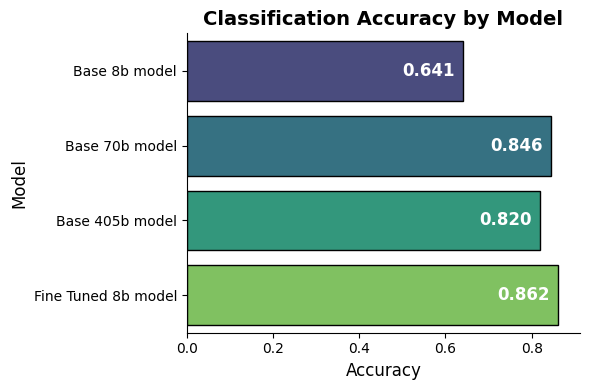

In [ ]:
# Rename dictionary
rename_dict = {
    'answer_base_8B': 'Base 8b model',
    'answer_base_70B': 'Base 70b model',
    'answer_base_405B': 'Base 405b model',
    'answer_ft_8B': 'Fine Tuned 8b model',
}

# Calculate accuracy for each model with renamed keys
accuracies = {}
for name in rename_dict:
    accuracy = test_df.apply(lambda row: row[name] in row['sentiment'], axis=1).mean()
    accuracies[rename_dict[name]] = accuracy

# Horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    y=list(accuracies.keys()),
    x=list(accuracies.values()),
    hue=list(accuracies.keys()),  # Add a hue based on the model names
    palette="viridis",
    edgecolor='black',
    ax=ax,
    legend=False  # Disable the unnecessary legend
)

# Add labels to bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_width() - 0.02,
            bar.get_y() + bar.get_height() / 2,
            f"{list(accuracies.values())[i]:.3f}",
            ha='right', va='center', color='white', fontsize=12, fontweight='bold')

# Set plot aesthetics
ax.set_xlim(0, max(accuracies.values()) + 0.05)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Classification Accuracy by Model', fontsize=14, fontweight='bold')
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

## Conclusion

As shown in the chart above, the fine-tuned model outperforms the base model with the provided training data and default hyperparameters. Training on 400 financial phrases with these defaults can take multiple hours. Once you complete this tutorial successfully, feel free to explore different hyperparameters, datasets, prompts, and the various models available from kluster.ai. Good luck!